# Discrete Fourier Transform

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nu = 5
t = linspace(0, 2*pi, nu)
F = fft.fft(np.eye(nu))
print(np.round(F, 1))

[[ 1. +0.j   1. -0.j   1. +0.j   1. -0.j   1. +0.j ]
 [ 1. +0.j   0.3-1.j  -0.8-0.6j -0.8+0.6j  0.3+1.j ]
 [ 1. +0.j  -0.8-0.6j  0.3+1.j   0.3-1.j  -0.8+0.6j]
 [ 1. +0.j  -0.8+0.6j  0.3-1.j   0.3+1.j  -0.8-0.6j]
 [ 1. +0.j   0.3+1.j  -0.8+0.6j -0.8-0.6j  0.3-1.j ]]


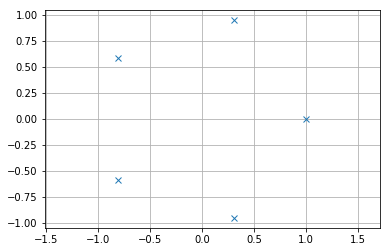

In [3]:
lam = exp(-1j*2*pi/nu)
z = lam**range(nu)
plt.plot(real(z), imag(z), 'x')
np.round(z, 2)
grid()
axis('equal');

In [4]:
lam = exp(-1j*2*pi/nu)
F2 = np.zeros((nu, nu), dtype=complex)
ak_vect = np.hstack([np.arange(0, nu//2 + 1), -np.arange(nu//2, 0, -1)])
j_vect = np.arange(nu)
print('ak:', ak_vect)
print('js:', j_vect)

for k in ak_vect:
    for j in j_vect:
        F2[j, k] = lam**(k*j)
print(np.round(F2, 1))

ak: [ 0  1  2 -2 -1]
js: [0 1 2 3 4]
[[ 1. +0.j   1. +0.j   1. +0.j   1. +0.j   1. +0.j ]
 [ 1. +0.j   0.3-1.j  -0.8-0.6j -0.8+0.6j  0.3+1.j ]
 [ 1. +0.j  -0.8-0.6j  0.3+1.j   0.3-1.j  -0.8+0.6j]
 [ 1. +0.j  -0.8+0.6j  0.3-1.j   0.3+1.j  -0.8-0.6j]
 [ 1. +0.j   0.3+1.j  -0.8+0.6j -0.8-0.6j  0.3-1.j ]]


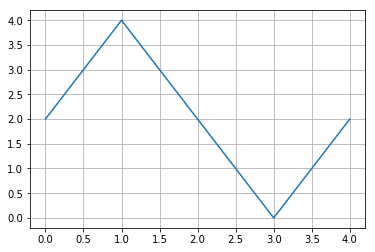

In [5]:
x = 2*sin(nu*t) + 2
plt.plot(x)
plt.grid()

Text(0, 0.5, '$|a_k|$')

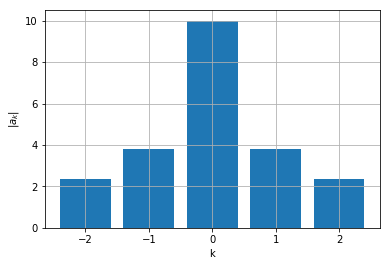

In [6]:
ak = F.dot(x)
plt.bar(ak_vect, abs(ak))
plt.grid()
plt.xlabel('k')
plt.ylabel('$|a_k|$')

Text(0, 0.5, '$|a_k|$')

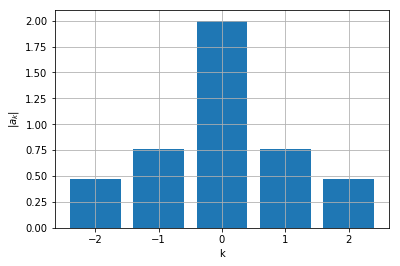

In [7]:
ak2 = inv(F2).dot(x)
plt.bar(ak_vect, abs(ak2))
plt.grid()
plt.xlabel('k')
plt.ylabel('$|a_k|$')

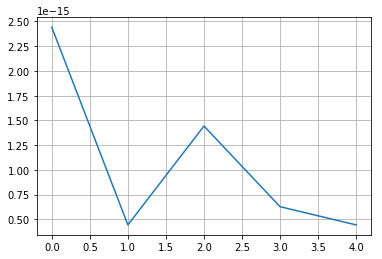

In [8]:
plot(np.abs(ak - conj(ak2)*nu))
plt.grid()

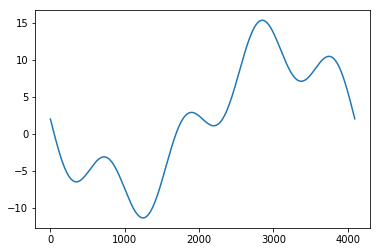

In [9]:
y = real(fft.fft([2], 4096)) + imag(fft.fft([0, 10, 0, 0, 4], 4096))
plot(y, label='real');
#plot(imag(fft.fft([0, 1], 4096)), label='real');
#legend()

In [10]:
#plot(real(fft.ifft([0, 1], 4096))*4096, label='real');
#plot(imag(fft.ifft([0, 1], 4096))*4096, label='real');
#legend()

# Nyquist Sampling Theorem/ Aliasing

initial sample time: 0.1 seconds
sampling interval: 6.9 seconds


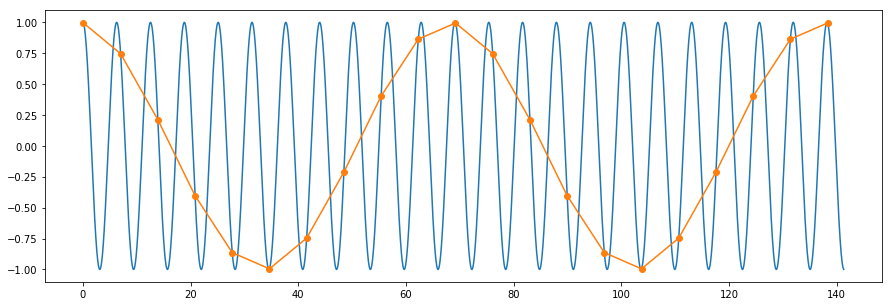

In [11]:
t = arange(0, 45*pi, pi/100)
T = 2*pi
dt = 1.1*T
t0 = 0.1

ts = arange(t0, 45*pi, dt)

figure(figsize=(15, 5))
plot(t, cos(t))
plot(ts, cos(ts), 'o-')

print('initial sample time: {:0.2g} seconds'.format(t0))
print('sampling interval: {:0.2g} seconds'.format(dt))

# Image Processing 

In [1]:
def add_noise(data, n):
    data2 = np.copy(data)
    for i in range(n):
        j = np.random.randint(0, data2.shape[0])
        k = np.random.randint(0, data2.shape[1])
        data2[j, k] = np.random.choice([0+100*np.random.rand(), 255 - 100*np.random.randn()])
    return data2

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def analysze_image(file, noise=0, n=30):
    img = cv2.imread(file, 0)
    img = add_noise(img, noise)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift_orig = np.copy(fshift)
    mag_spectrum = 20*np.log(np.abs(fshift_orig))

    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2
    fshift_high = np.copy(fshift)
    fshift_high[crow-n:crow+n, ccol-n:ccol+n] = 0
    mag_spectrum_high = 20*np.log(np.abs(fshift_high) + 1e-20)
    f_ishift = np.fft.ifftshift(fshift_high)
    img_high = np.fft.ifft2(f_ishift)
    img_high = np.real(img_high)

    img_low = img - img_high
    mag_spectrum_low = 20*np.log(np.abs(fshift_orig - fshift_high) + 1e-20)
    
    vmin = 0
    vmax = 255

    plt.figure(figsize=(15, 4))
    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image')
    plt.axis('tight')

    plt.subplot(122),plt.imshow(mag_spectrum, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('tight')
    plt.title('Magnitude Spectrum, dB, $20\log(|a_k|)$')
    plt.show()

    plt.figure(figsize=(15, 4))
    plt.subplot(121),plt.imshow(img_high, cmap = 'gray', vmin=-vmax, vmax=vmax)
    plt.title('Image after High Pass Filter')
    plt.axis('tight')

    plt.subplot(122), plt.imshow(mag_spectrum_high, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('tight')
    plt.title('Magnitude Spectrum, dB, $20\log(|a_k|)$')

    plt.figure(figsize=(15, 4))
    plt.subplot(121),plt.imshow(img_low, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.title('Image after Low Pass Filter')
    plt.axis('tight')

    plt.subplot(122), plt.imshow(mag_spectrum_low, cmap = 'gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('tight')
    plt.title('Magnitude Spectrum, dB, $20\log(|a_k|)$')


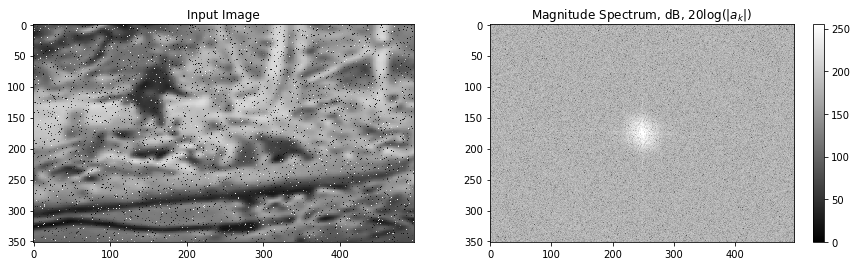

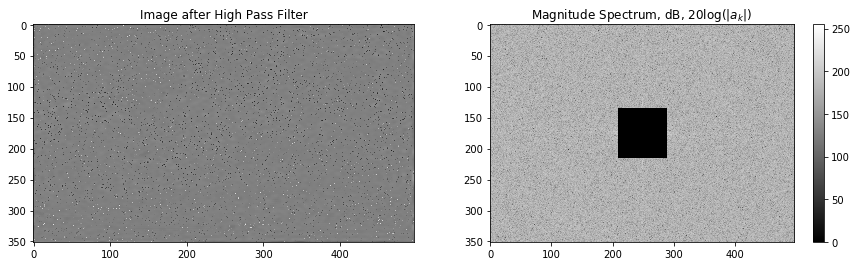

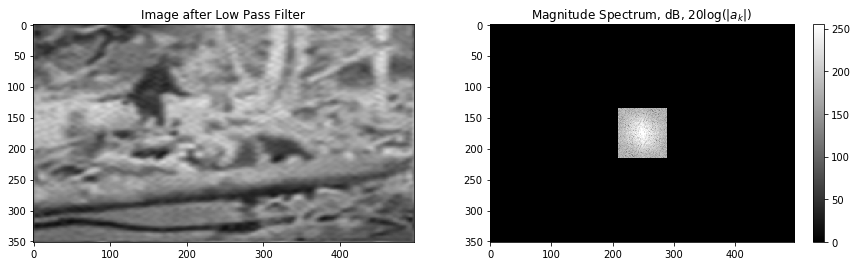

In [3]:
analysze_image('./data/bigfoot.png', noise=10000, n=40)

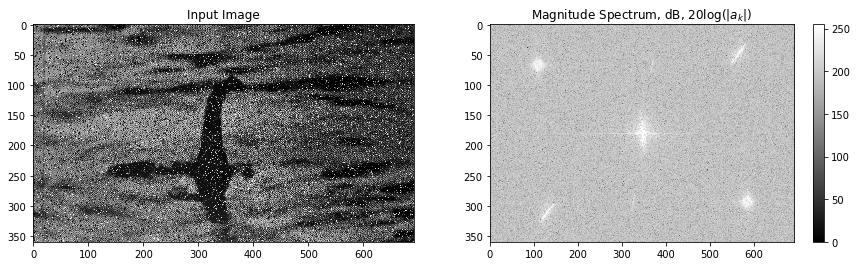

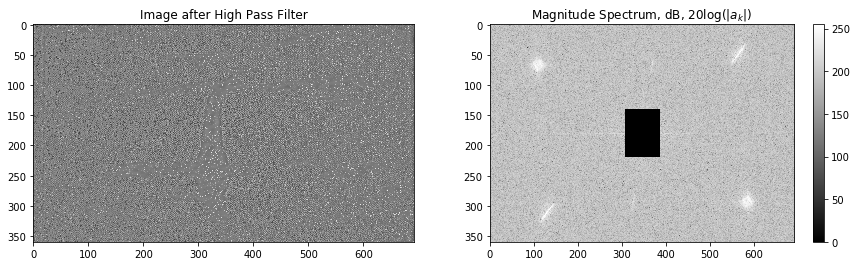

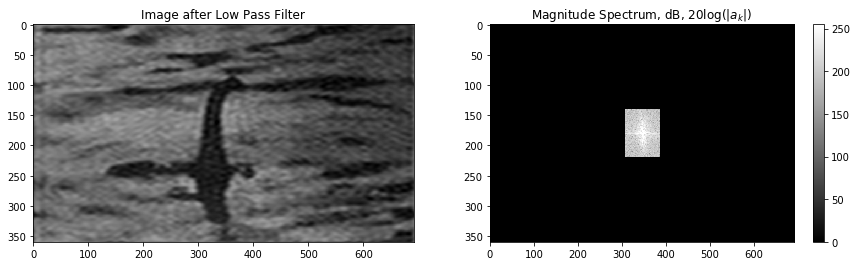

In [4]:
analysze_image('./data/nessy.jpg', noise=50000, n=40)